# Code and detailed explanation

`--------------------------------------------------------------------------------------------------------`

Ratings data even though represented by numbers shouldn't be reduced to its mean. That's because we don't believe the difference between two consecutive ratings are the same, for e.g difference between rating 0 and 0.5 is not the same as difference between rating 0.5 and 1. Ratings are sujective therefore the small difference in ratings are not meaningful. We know that there is a clear order in which ratings are classified. Hence, ratings are ordinal, i.e. categories that are ordered, and there are 9 possible ratings (0-4 spaced by 0.5).  

We would use Chi-square test only if the data is categorical, but not ordered. So, we are left with some options Wilcoxon-Mann Whitney, wilcoxon signed-rank, Kruskal Wallis and Kolmogorov-Smirnov test.   	



Mann-Whitney U test is for independent samples and Wilcoxon signed-rank test is for related / paired samples. Kruskal-Wallis H-test tests the null hypothesis that the population median of two or more groups are equal. But, it doesn't allow one-sided test, so it is not appropriate for questions that are asking us to compute if one variable is more meaningful (different) than another.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def convert_to_numeric(data):
    """
    input: dataframe
    output: datatframe with all of its columns' converted to numeric  
    """
    for i in range(data.ndim):
        data.iloc[:,i]= data.iloc[:,i].apply(pd.to_numeric, errors='coerce') 
    return data

# if we need to remove nan element-wise
def remove_nan_ele(data):
    """
    input: dataframe, pandas csv, array 
    output: data with rows with nans removed if one dimension, rows removed if all dimensions are nans  
    """
    return data[np.isfinite(data)]

# if we need to remove nan row-wise
def remove_nan_row(data):
    """
    input: dataframe, pandas csv, array 
    output: data with entire row removed if any of it's dimension is nan
    """
    new_comb_data = data.dropna()  
    return new_comb_data

In [2]:
df = pd.DataFrame(pd.read_csv('movieReplicationSet.csv'))
print("Dimension of the original data:",df.shape,"\n")

#grab the columns that are movie ratings
movie_ratings_df = convert_to_numeric(df.iloc[:,0:400])
print("Dimension of the rating data:", movie_ratings_df.shape,"\n")
print("Possible ratings are", np.sort(movie_ratings_df.iloc[:,1].dropna().unique()),"\n")

#grab the columns that are behaviour questions
other_questions_df = df.iloc[:,400:]
print("Dimension of the non rating data:", other_questions_df.shape)


Dimension of the original data: (1097, 477) 

Dimension of the rating data: (1097, 400) 

Possible ratings are [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ] 

Dimension of the non rating data: (1097, 77)


Questions corporate would like you to answer in the report (each is worth 10% of the grade score):
### 1)  Are movies that are more popular (operationalized as having more ratings) rated higher than movies that are less popular?
[Hint: You can do a median-split of popularity to determine high vs. low popularity movies]

I will assume that the popularity can be measured by how many people have watched the movie and use the number of ratings as a proxy. It is just a proxy because there might be people who watched the movie, but did not want to rate it or were not a part of the survey. After counting the number of ratings per movie (non missing), I divided the movies into two groups (low vs high) based on whether the count is below or above the median count.

There are different ways one can divide the group further before performing test/s. We can perform the tests one vs one (200 by 200 times) or one movie from the first group vs all movies from the second group (200 times) then determine how to combine the results to come to a conclusion. First option sounds tedious and the second option sounds biased. Instead I decided to stack all the ratings within the group and compare only once as if the ratings were for a single movie. The caveat with stacking the ratings is that it led to a very uneven number of rows between two groups (90k more popular and 22k less). This is expected as more popular means more ratings and grouping them together obviously skews the split. So, instead of using each rating as an individual data point, I took the median rating for each movie such that we end up with an even number of data points (200 on each group).

Next, determining the right statistical test was tricky. We know that movie ratings are not independent because when the same person rates movies, how she rates the next movie would be in comparison to her previous ratings, at least that's how I do ratings. But, we will assume independence for this question. Since, we are taking medians per movie we not comparing paired samples, so we shouldn't use a paired test. So, to check if movies that are more popular rated higher than movies that are less popular I performed one-sided Mann-Whitney U rank test, which tests median between two distributions. The resulted p-value was 9.93e-35, so I rejected the null hypothesis and concluded that the movies that are more popular are rated higher than movies that are less popular. If we simply look at the histogram of two groups we can clearly see that the distributions are different. More popular movies have more high ratings compared to less popular movies.




In [3]:
cnt_watch= movie_ratings_df.notnull().sum(axis = 0)
cnt_watch_median = statistics.median(cnt_watch)
print("Median number of people who watched the movies:", cnt_watch_median)

# create two new lists with index if the number of people who rated the movie is above or below median 
is_popular = []
isnot_popular = []
for i in range(len(cnt_watch)):
    if cnt_watch[i] < cnt_watch_median:
        isnot_popular.append(i)
    elif  cnt_watch[i] >= cnt_watch_median:
        is_popular.append(i)
        
print("Number of movies marked as high popularity:", len(is_popular))
print("Number of movies marked as low popularity:", len(isnot_popular))

#select columns with the index in is_popular
median_movie_ratings_df  = pd.DataFrame(movie_ratings_df.median(axis =0)).T
popular_movies = median_movie_ratings_df.iloc[:,is_popular]
not_popular_movies = median_movie_ratings_df.iloc[:,isnot_popular]

Median number of people who watched the movies: 197.5
Number of movies marked as high popularity: 200
Number of movies marked as low popularity: 200


200
200
9.929258851707232e-35


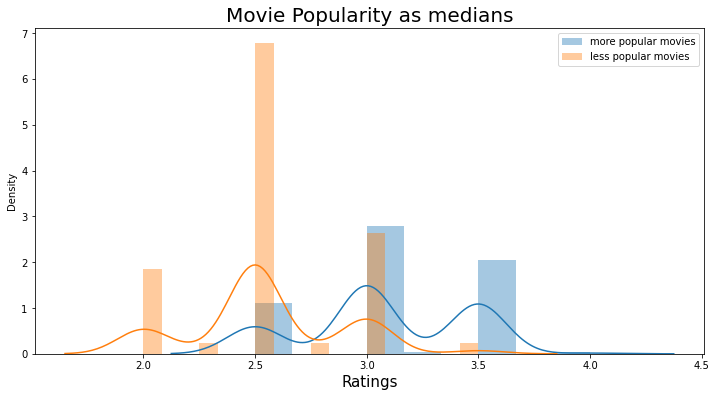

In [4]:
def stack_columns(data):
    comb_data = pd.DataFrame(data.stack().reset_index())
    comb_data.rename(columns={'level_0':'movie index', 'level_1':'movie', 0 :'ratings'}, inplace=True)
    return comb_data

comb_popular_movies = stack_columns(popular_movies).loc[:,'ratings']
print(len(comb_popular_movies))

comb_not_popular_movies = stack_columns(not_popular_movies).loc[:,'ratings']
print(len(comb_not_popular_movies))

#no need to remove nans because all movies have at least one ratings so taking medians led to no nans
h,p = stats.mannwhitneyu(comb_popular_movies, comb_not_popular_movies, alternative="greater")
print(p)

def plt_distplot(data1, data2, label1, label2, main_title):
    plt.figure(figsize=(12,6))
    sns.distplot(data1, label =label1)
    sns.distplot(data2, label =label2)
    plt.xlabel("Ratings",fontsize = 15)
    plt.title(main_title,fontsize = 20)
    plt.legend()
    plt.show()
    
plt_distplot(comb_popular_movies, comb_not_popular_movies, "more popular movies", "less popular movies","Movie Popularity as medians")

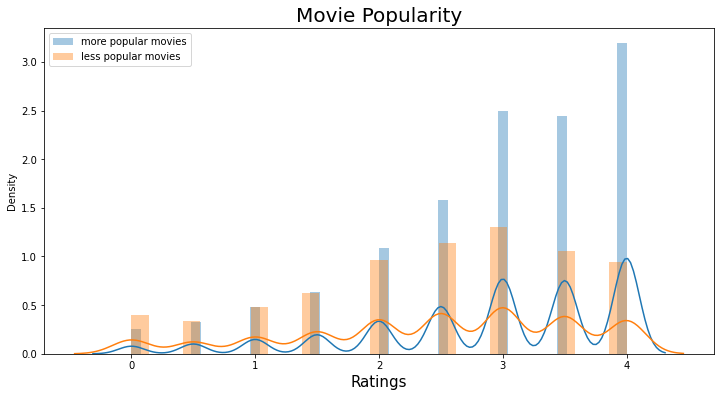

In [5]:
pm= stack_columns(movie_ratings_df.iloc[:,is_popular]).loc[:,'ratings']
npm= stack_columns(movie_ratings_df.iloc[:,isnot_popular]).loc[:,'ratings']
plt_distplot(pm, npm, "more popular movies", "less popular movies","Movie Popularity")


### 2) Are movies that are newer rated differently than movies that are older? 
[Hint: Do a median split of year of release to contrast movies in terms of whether they are old or new]

To find the year of release for each movie we need to grab the year within the parenthesis from the column header. There can be movies with four digits in its name that don't represent its year of release, so it is crucial to check if the year of releases are reasonable. Then there is one movie, "Rambo: First Blood Part II", that did not have a year. Since it is better to have more data, I went ahead and searched the year that movie was released then added the year. Next problem was the median year 1999, which appeared 29 times, so I couldn't use the value to split the data because one side of the group will have 29 more movies. Instead, I decided to sort the movies by year and split them into half. I also shuffled the years before sorting it just so that the 1999 movies are shuffled before the split. It is best practice to check if things are working as intended so after the split I produced general stats such as min and max. Now that I have two groups, I performed a two-sided MannWhitney U test to check if movies that are newer rated differently than movies that are older. The p-value I got was 0.1134 so using significance test level  of 0.005, we don't reject the null hypothesis and conclude that there is not a strong evidence that the movies that are newer are rated differently than movies that are older. If we look at the histogram, we can see a very slight difference in their distributions.


In [6]:
#grab the year from movie name
no_year = []
movie_n_year = []
import re
for i in range(400):
    movie_name = movie_ratings_df.columns[i]
    if bool(re.match('.+(\d{4}).+', movie_name)) == False: 
        no_year.append(movie_name)
        #print movies without year
        print(i, movie_name, "\n")
    else:       
        movie_n_year.append([movie_name, int(movie_name[movie_name.find("(")+1:movie_name.find(")")])])
        
movie_n_year.append(['Rambo: First Blood Part II', 1985])
movie_n_year = pd.DataFrame(movie_n_year, columns = ['movie','year'])

#general stats of the year
#print(movie_n_year['year'].describe())

# Median year and number of times it appears
median_year = int(movie_n_year['year'].median())
print("\nMedian year is ",median_year , "and it appears", len(movie_n_year[movie_n_year['year'] == movie_n_year['year'].median()]), "times.")

6 Rambo: First Blood Part II 


Median year is  1999 and it appears 29 times.


In [7]:
movie_n_year_shuf = movie_n_year.sample(frac=1,random_state=1).reset_index(drop=True).sort_values(by=['year']).reset_index(drop=True)
old_movies = movie_n_year_shuf[:200]
new_movies = movie_n_year_shuf[200:]
old_movie_n = old_movies['movie'].tolist()
new_movie_n = new_movies['movie'].tolist()
#print(old_movies['year'].describe())
#print(new_movies['year'].describe())

0.11342601865318032


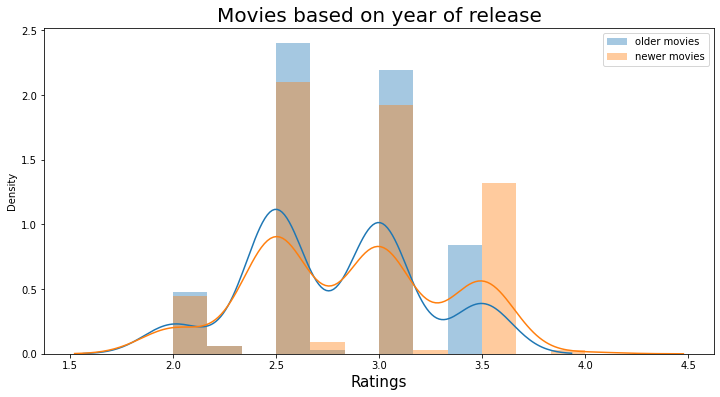

In [8]:
movie_ratings_df_old = movie_ratings_df[old_movie_n].median(axis=0) #stack_columns(movie_ratings_df[old_movie_n].median(axis))
movie_ratings_df_new = movie_ratings_df[new_movie_n].median(axis=0) #stack_columns(movie_ratings_df[new_movie_n])
h,p = stats.mannwhitneyu(movie_ratings_df_old, movie_ratings_df_new, alternative="two-sided")
print(p)
plt_distplot(movie_ratings_df_old, movie_ratings_df_new, "older movies", "newer movies","Movies based on year of release")

### 3) Is enjoyment of ‘Shrek (2001)’ gendered, i.e. do male and female viewers rate it differently?


Among the raters 807 are females, 260 are males and 6 are self-described. There is a clear difference in the sample size between female and male. Since we are not performing paired sample tests, it is not necessary to have the same sample size. Still the big difference in sample size must be of concern. To find if enjoyment of ‘Shrek (2001)’ was gendered, I performed a two-sided MannWhitney U test and got a p-value of 0.050, so I concluded that there is not a strong evidence that enjoyment of ‘Shrek (2001)’ gendered.


In [9]:
# count the number of female raters
female = df[df['Gender identity (1 = female; 2 = male; 3 = self-described)'] ==1]
print("number of female raters:", len(female))
female_ratings= stack_columns(female)['ratings'] # can't use .dropna() because nan are converted to -1 by default
print(female_ratings[female_ratings >-1].describe())

# count the number of male raters
male = df[df['Gender identity (1 = female; 2 = male; 3 = self-described)'] ==2]
#print("number of male raters:", len(male))
male_ratings= stack_columns(male)['ratings'].dropna()
#print(male_ratings[male_ratings>-1].describe())

number of female raters: 807
count    138775.000000
mean          2.991465
std           1.201632
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: ratings, dtype: float64


96830.5 0.050536625925559006


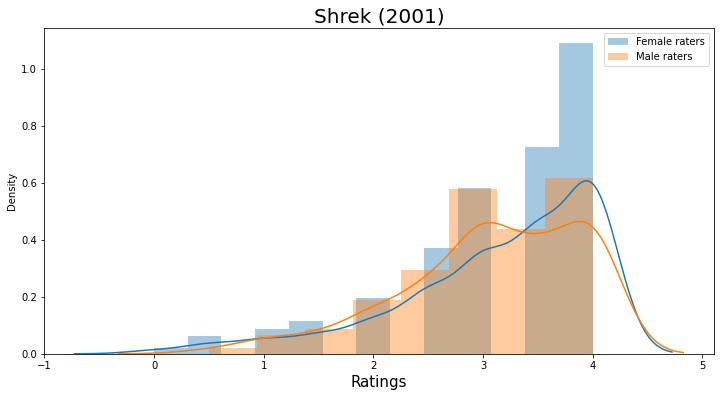

In [10]:
Shrek_df = df.loc[:,['Shrek (2001)','Gender identity (1 = female; 2 = male; 3 = self-described)']]
#since the male and female raters are in the same column removing the nans row-wise will simply remove the rows with no rating 
Shrek_df_clean= remove_nan_row(Shrek_df)
Shrek_df_female= Shrek_df_clean.loc[Shrek_df_clean['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 1]
Shrek_df_male = Shrek_df_clean.loc[Shrek_df_clean['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2]

h,p = stats.mannwhitneyu(Shrek_df_female.iloc[:,0], Shrek_df_male.iloc[:,0], alternative="two-sided")
print(h,p)

plt_distplot(Shrek_df_female.iloc[:,0], Shrek_df_male.iloc[:,0], "Female raters", "Male raters","Shrek (2001)")

### 4) What proportion of movies are rated differently by male and female viewers?

To observe the proportion of movies rated differently by male and female viewers, we need to extend the previous question for the movie "Shrek" to all of the other 399 movies. For each movie I  performed a two-sided MannWhitney U test and grouped the movies into one if the p-value is less than 0.005 and found the ratio to be 0.125.


In [11]:
column_names = df.columns
c_rated_diff_sex = 0
for i in range(400):
    select_df = df.loc[:,[column_names[i],'Gender identity (1 = female; 2 = male; 3 = self-described)']]
    #this loop runs for each movie and since the male and female raters are in the same column removing the nans row-wise will simply remove the rows with no rating 
    select_df_clean= remove_nan_row(select_df)
    select_df_female= select_df_clean.loc[select_df_clean['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 1]
    select_df_male = select_df_clean.loc[select_df_clean['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2]

    h,p = stats.mannwhitneyu(select_df_female.iloc[:,0], select_df_male.iloc[:,0], alternative="two-sided")
    
    if p < 0.005:
        c_rated_diff_sex +=1

c_rated_diff_sex/400   

0.125


### 5) Do people who are only children enjoy ‘The Lion King (1994)’ more than people with siblings?

To check if people who are only children enjoy ‘The Lion King (1994)’ more than people with siblings, I divided the population who rated ‘The Lion King (1994)’ into two groups: who are only children and who have siblings. Similar to previous questions, I performed Mann Whitney U test for unpaired samples assuming independence. Since the question asks if one group enjoys the movie more than another group, I used a one-sided test and got a p-value of 0.978. Therefore, I conclude that there is not strong evidence that the movie ‘The Lion King (1994)’ is enjoyed by people who are only children more than people with siblings.


In [12]:
LionKing_df = df.loc[:,['The Lion King (1994)','Are you an only child? (1: Yes; 0: No; -1: Did not respond)']]
LionKing_no_siblings = LionKing_df.loc[LionKing_df['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 1]
LionKing_no_siblings_ele = remove_nan_ele(LionKing_no_siblings.iloc[:,0])
LionKing_has_siblings = LionKing_df.loc[LionKing_df['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 0]
LionKing_has_siblings_ele = remove_nan_ele(LionKing_has_siblings.iloc[:,0])

0.978419092554931


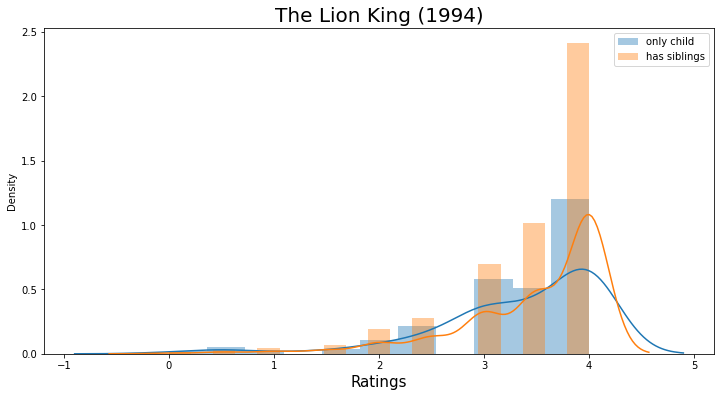

In [13]:
h,p = stats.mannwhitneyu( LionKing_no_siblings_ele,LionKing_has_siblings_ele,alternative = "greater")
print(p)

plt_distplot(LionKing_no_siblings_ele,LionKing_has_siblings_ele, "only child", "has siblings", "The Lion King (1994)")


### 6) What proportion of movies exhibit an “only child effect”, i.e. are rated different by viewers with siblings vs. those without?

To compute the proportion of movies that exhibit an “only child effect”, I performed a two-sided Mann Whitney U test for each movie and grouped the ones with significant p-values. There were only 7 out of 400 movies (0.0175) that exhibited an “only child effect”. I think an extension of this problem could be to find what is so different about these movies. I thought it is particularly interesting that out of .... Star Wars episodes "The Return of the Jedi" was the only one with the effect. The effect we are seeing could still happen just by chance, so there might not be even any meaningful difference. This is a different kind of question and out of scope for this project, so I am moving on to the next question.

Eyeballing the histograms doesn't always tell us the same information and the p-value obtained using statistical tests. For example, the movie "3000 Miles to Graceland (2001)" has a p-value of 0.62, but the histogram looks different to my eyes (the ratings from people who have siblings are uniformly distributed and those who are only children peaked around 2-2.5).


0.6233021105832455


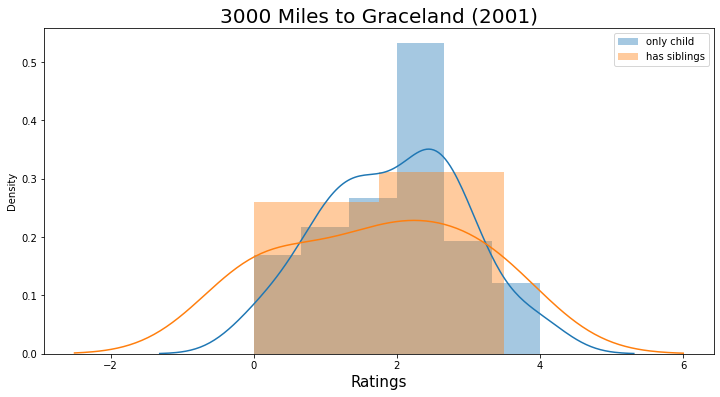

Proportion of movies that exhibit an "only child effect" is 0.0175


In [14]:
c_rated_diff_child = 0
for i in range(400):
    select_df = df.loc[:,[column_names[i],'Are you an only child? (1: Yes; 0: No; -1: Did not respond)']]
    select_no_siblings = select_df.loc[select_df['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 1]
    select_no_siblings_ele = remove_nan_ele(select_no_siblings.iloc[:,0])
    select_has_siblings = select_df.loc[select_df['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 0]
    select_has_siblings_ele = remove_nan_ele(select_has_siblings.iloc[:,0])
    h,p = stats.mannwhitneyu( select_has_siblings_ele,  select_no_siblings_ele, alternative = "two-sided")
    
    if(column_names[i] == "3000 Miles to Graceland (2001)"):
        print(p)
        plt_distplot(select_has_siblings_ele,  select_no_siblings_ele, "only child", "has siblings", column_names[i])
    
    if p < 0.005:
        #print(column_names[i])
        #print(p)
        c_rated_diff_child += 1
    
print("Proportion of movies that exhibit an \"only child effect\" is", c_rated_diff_child /400 )

In [15]:
c_rated_diff_child

7

### 7) Do people who like to watch movies socially enjoy ‘The Wolf of Wall Street (2013)’ more than those who prefer to watch them alone?

To find out if people who like to watch movies socially enjoy ‘The Wolf of Wall Street (2013)’ more than those who prefer to watch them alone, I performed a one-sided Mann Whitney U test and found the p-value of 0.94. Therefore, I conclude that there is not strong evidence that people who like to watch movies socially enjoy ‘The Wolf of Wall Street (2013)’ more than those who prefer to watch them alone.



0.9436657996253056


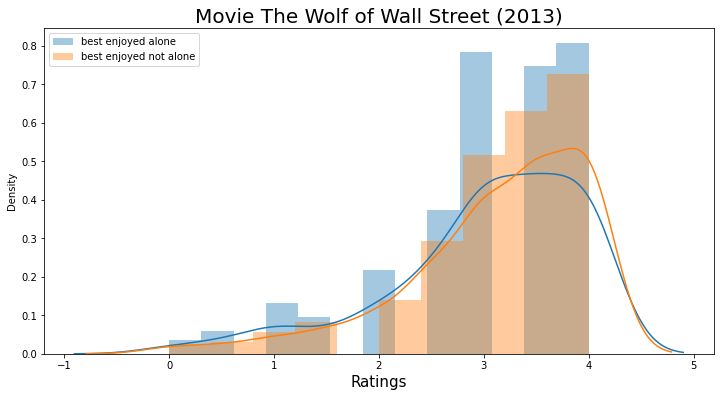

In [16]:
WallStreet_df = df.loc[:,['The Wolf of Wall Street (2013)','Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)']]
WallStreet_alone = WallStreet_df.loc[WallStreet_df['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1]
WallStreet_alone_ele = remove_nan_ele(WallStreet_alone.iloc[:,0])
WallStreet_not_alone = WallStreet_df.loc[WallStreet_df['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0]
WallStreet_not_alone_ele = remove_nan_ele(WallStreet_not_alone.iloc[:,0])
h,p = stats.mannwhitneyu(WallStreet_not_alone_ele,WallStreet_alone_ele, alternative = "greater")
print(p)

plt_distplot(WallStreet_not_alone_ele,WallStreet_alone_ele,"best enjoyed alone", "best enjoyed not alone", "Movie The Wolf of Wall Street (2013)")


### 8) What proportion of movies exhibit such a “social watching” effect?

To find out proportion of movies exhibit such a “social watching” effect, I performed the same one-sided Mann Whitney U test and grouped the movies that showed significant p-value into one and found that 6 out of 400 movies (0.015) exhibited such a “social watching” effect.

In [17]:
c_rated_diff_social = 0
for i in range(400):
    select_df = df.loc[:,[column_names[i],'Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)']]
    select_df_alone = select_df.loc[select_df['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1]
    select_df_alone_ele = remove_nan_ele(select_df_alone.iloc[:,0])
    select_df_not_alone = select_df.loc[select_df['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0]
    select_df_not_alone_ele = remove_nan_ele(select_df_not_alone.iloc[:,0])
  
    h,p = stats.mannwhitneyu(select_df_not_alone_ele,select_df_alone_ele, alternative = "greater")
    h,p = stats.mannwhitneyu(select_df_not_alone_ele,select_df_alone_ele)
 
    if p < 0.005:
        print(column_names[i])
        c_rated_diff_social +=1

c_rated_diff_social/400   

The Silence of the Lambs (1991)
North (1994)
Inglorious Bastards (2009)
Shrek 2 (2004)
The Avengers (2012)
Spider-Man (2002)
Donnie Darko (2001)
Apocalypse Now (1979)
The Transporter (2002)
Captain America: Civil War (2016)


0.025

In [18]:
c_rated_diff_social

10

### 9) Is the ratings distribution of ‘Home Alone (1990)’ different than that of ‘Finding Nemo (2003)’?

The difference in ratings distributions can be found using Kolmogorov-Smirnov test. One drawback of KS test that came to my attention was that the test tends to be more sensitive near the center of the distribution than at the tails. Anderson-Darling test counters that drawback, but I was not able to use it because the scipy's version of A-D test only compares the distribution of one series of input data against some of the common distributions normal, exponential, logistic, or Gumbel. But, to answer ‘Home Alone (1990)’ different than that of ‘Finding Nemo (2003)’ we need to perform two sample test. Therefore, I performed K-S two sample test and got p-value of 2.20e-10. Therefore, I conclude that the ratings distribution of ‘Home Alone (1990)’ is different than that of ‘Finding Nemo (2003)’. 

2.2038507937682687e-10


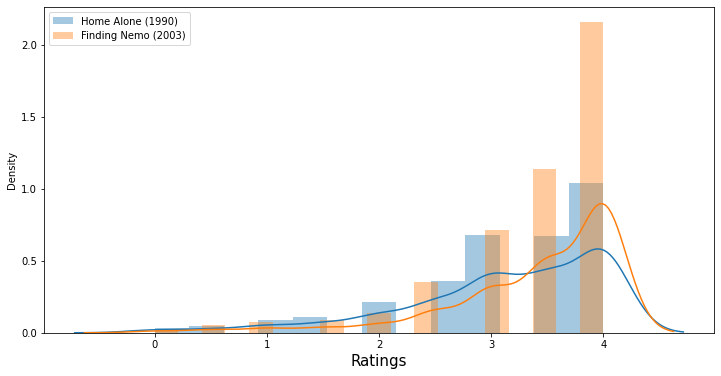

In [19]:
home_alone_finding_nemo_df = remove_nan_row(df.loc[:,['Home Alone (1990)','Finding Nemo (2003)' ] ])
home_alone_df_row = home_alone_finding_nemo_df.loc[:,'Home Alone (1990)' ]
finding_nemo_df_row = home_alone_finding_nemo_df.loc[:,'Finding Nemo (2003)' ]

h, p = stats.ks_2samp(home_alone_df_row, finding_nemo_df_row)
h, p = stats.kstest(home_alone_df_row, finding_nemo_df_row)

print(p)

plt_distplot(home_alone_df_row, finding_nemo_df_row,"Home Alone (1990)", "Finding Nemo (2003)", "")

In [20]:
franchises = ["Star Wars", "Harry Potter", "The Matrix", "Indiana Jones", "Jurassic Park", "Pirates of the Caribbean", "Toy Story", "Batman"]
cnt_inconsistent = 0
for f in franchises:
    matching = [s for s in movie_ratings_df.columns if f in s]
    #print(matching,"\n")
    select_df = df.loc[:, matching]
    new_df_row = remove_nan_row(select_df)
    args=[new_df_row[l] for l in new_df_row]
    print(args)
    h,p = stats.kruskal(*args)
    #print("p-value for", f, p,"\n")
    if p <0.005:
        cnt_inconsistent+=1
        
print("Number of movies with inconsistent qualities: ", cnt_inconsistent)     

[3       4.0
5       4.0
7       3.0
9       4.0
19      4.0
       ... 
1084    4.0
1086    4.0
1090    3.5
1093    4.0
1094    3.0
Name: Star Wars: Episode IV - A New Hope (1977), Length: 333, dtype: float64, 3       0.0
5       3.5
7       4.0
9       2.0
19      0.0
       ... 
1084    2.5
1086    4.0
1090    3.5
1093    3.0
1094    1.5
Name: Star Wars: Episode II - Attack of the Clones (2002), Length: 333, dtype: float64, 3       4.0
5       4.0
7       4.0
9       4.0
19      4.0
       ... 
1084    4.0
1086    4.0
1090    4.0
1093    3.5
1094    3.0
Name: Star Wars: Episode V - The Empire Strikes Back (1980), Length: 333, dtype: float64, 3       0.0
5       4.0
7       4.0
9       4.0
19      0.0
       ... 
1084    2.0
1086    4.0
1090    3.5
1093    4.0
1094    2.5
Name: Star Wars: Episode 1 - The Phantom Menace (1999), Length: 333, dtype: float64, 3       2.5
5       4.0
7       4.0
9       4.0
19      3.0
       ... 
1084    3.5
1086    4.0
1090    3.5
1093    4.0
1094    4.

### Extra Credit: Tell us something interesting and true (supported by a significance test of some kind) about the movies in this dataset that is not already covered by the questions above [for 5% of the grade score].

Since we have a good amount of behaviour data, I am interested in checking how much of the biases or inherent differences in gender we know or believe in, are represented in the data. Some of the behaviour expectations we put on females are that they are emotional, moody, get scared easily, and on male are that they are risk-takers and emotionally stable. 

For each non movie rating question, I wanted to know the answers to which of the questions are significantly different between gender. I did not want to do a two-sided test as it only tells me that there is a difference, but not which gender is inclined to one side of the spectrum. I was careful to not do a one-sided test for only one fixed gender because doing so, we would not know whether there is no difference or the other-sided test is significant. Therefore, for each question, I first performed a one-sided Mann Whitney U test to check if females are inclined to the higher spectrum. Second, I performed a one-sided Mann Whitney U test to check if male is inclined to the higher spectrum.  

Out of 77 questions, 17 questions had greater effect for females than male, and 7 questions had greater effect for male than females. The expectations previously mentioned were reflected in the data. I do not believe that this data suggests anything about the biological differences in behaviours, instead I believe that it shows the internal biases or learnt differences.


The questions where female seems to be more inclined than male were: 
- I enjoy impulse shopping
- I enjoy going to large music or dance festivals 
- I had a sheltered upbringing
- My life is very stressful
- Is talkative
- Is a reliable worker
- Can be tense
- Worries a lot
- Can be moody
- Is considerate and kind to almost everyone
- Gets nervous easily
- I have cried during a movie
- When watching a movie I cheer or shout or talk or curse at the screen
- When watching a movie I feel like the things on the screen are happening to me
- The emotions on the screen "rub off" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared
- Movies change my position on social economic or political issues
- When watching movies things get so intense that I have to stop watching

The questions where male seems to be more inclined than female were: 

- I enjoy driving fast
- Have you gambled or bet for money?
- Is relaxed/handles stress well
- Is emotionally stable/not easily upset
- is inventive
- Can be cold and aloof
- Remains calm in tense situations


In [21]:
other_questions = other_questions_df.columns.values.tolist()
other_questions.remove('Gender identity (1 = female; 2 = male; 3 = self-described)')

female_more = []
male_more = []

for c in other_questions:
    gender_df = df.loc[:,[c,'Gender identity (1 = female; 2 = male; 3 = self-described)']]
    gender_df_clean= remove_nan_row(gender_df)
    gender_df_female= gender_df_clean.loc[gender_df_clean['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 1]
    gender_df_male = gender_df_clean.loc[gender_df_clean['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2]

    h,p = stats.mannwhitneyu(gender_df_female.iloc[:,0], gender_df_male.iloc[:,0], alternative="greater")
    if p < 0.005:
        female_more.append([c,p])
        #print(c)
        #print(p)
        #plt_distplot(test_df_female.iloc[:,0], test_df_male.iloc[:,0], "Female raters", "Male raters", c)
    else:
        h,p = stats.mannwhitneyu(gender_df_female.iloc[:,0], gender_df_male.iloc[:,0], alternative="less")
        if p < 0.005:
            male_more.append([c,p])
            #print(c)
            #print(p)
            #plt_distplot(test_df_female.iloc[:,0], test_df_male.iloc[:,0], "Female raters", "Male raters", c)
            
print("Number of questions:", len(other_questions),"\n")
print("Number of questions with female having greater effect:", len(female_more),"\n")
#print(female_more,"\n")
print("Number of questions with male having greater effect:",len(male_more),"\n")
#print(male_more)

Number of questions: 76 

Number of questions with female having greater effect: 17 

Number of questions with male having greater effect: 7 

